In [1]:
#%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

/Users/shahriyar/miniforge3/envs/pytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/shahriyar/miniforge3/envs/pytorch/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/shahriyar/miniforge3/envs/pytorch/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <DB251723-D0A7-3D18-91AD-79131BDBDDBC> /Users/shahriyar/miniforge3/envs/pytorch/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [3]:
# Load the Data



# train_path = "/Users/shahriyar/Desktop/programming/Python/ML/Pytorch/birds_classification/data/train"
# val_path = "/Users/shahriyar/Desktop/programming/Python/ML/Pytorch/birds_classification/data/validation"
# test_path = "/Users/shahriyar/Desktop/programming/Python/ML/Pytorch/birds_classification/data/test" 
# batch_size = 64
# transform = transforms.Compose([
#     transforms.Resize(64),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.229, 0.224, 0.225])
# ])
# train_folder = torchvision.datasets.ImageFolder(root=train_path, transform=transform)
# valid_folder = torchvision.datasets.ImageFolder(root=val_path, transform=transform)
# test_folder = torchvision.datasets.ImageFolder(root=test_path, transform=transform)
# train_ds = DataLoader(train_folder, batch_size=batch_size)
# valid_ds = DataLoader(valid_folder, batch_size=batch_size)
# test_ds = DataLoader(test_folder, batch_size=batch_size)

dataset = '/Users/shahriyar/Desktop/programming/Python/ML/Pytorch/birds_classification/data'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'validation')
test_directory = os.path.join(dataset, 'test')

# Batch size
bs = 32

# Number of classes
num_classes = len(os.listdir(valid_directory))  #10#2#257
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

200
{0: '001.Black_footed_Albatross', 1: '002.Laysan_Albatross', 2: '003.Sooty_Albatross', 3: '004.Groove_billed_Ani', 4: '005.Crested_Auklet', 5: '006.Least_Auklet', 6: '007.Parakeet_Auklet', 7: '008.Rhinoceros_Auklet', 8: '009.Brewer_Blackbird', 9: '010.Red_winged_Blackbird', 10: '011.Rusty_Blackbird', 11: '012.Yellow_headed_Blackbird', 12: '013.Bobolink', 13: '014.Indigo_Bunting', 14: '015.Lazuli_Bunting', 15: '016.Painted_Bunting', 16: '017.Cardinal', 17: '018.Spotted_Catbird', 18: '019.Gray_Catbird', 19: '020.Yellow_breasted_Chat', 20: '021.Eastern_Towhee', 21: '022.Chuck_will_Widow', 22: '023.Brandt_Cormorant', 23: '024.Red_faced_Cormorant', 24: '025.Pelagic_Cormorant', 25: '026.Bronzed_Cowbird', 26: '027.Shiny_Cowbird', 27: '028.Brown_Creeper', 28: '029.American_Crow', 29: '030.Fish_Crow', 30: '031.Black_billed_Cuckoo', 31: '032.Mangrove_Cuckoo', 32: '033.Yellow_billed_Cuckoo', 33: '034.Gray_crowned_Rosy_Finch', 34: '035.Purple_Finch', 35: '036.Northern_Flicker', 36: '037.Acadia

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print('Using device:', device)
# model.to(device)
# print(len(train_folder.classes))

print(train_data_size, valid_data_size, test_data_size)

Using device: mps
3000 530 2503


In [12]:
# Load pretrained ResNet50 Model

resnet50_model = models.resnet50(pretrained=True)
resnet50 = resnet50_model.to(device)
print(device)

/Users/shahriyar/miniforge3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shahriyar/miniforge3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


mps


In [13]:
# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

In [14]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), # Since 10 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)



# Convert model to be used on GPU
resnet50 = resnet50.to(device)


In [17]:
# Define Optimizer and Loss Function
learning_rate = 0.0001
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50_model.parameters(),lr=learning_rate)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

NameError: name 'model' is not defined

In [18]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'renet50_model_1.pt')
            
    return model, history, best_epoch
    

In [19]:
# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 25 epochs
num_epochs = 30
trained_model, history, best_epoch = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history,'model_history.pt')

Epoch: 1/30
Epoch : 000, Training: Loss - 5.3009, Accuracy - 0.5333%, 
		Validation : Loss - 5.2492, Accuracy - 0.9434%, Time: 29.8288s
Epoch: 2/30
Epoch : 001, Training: Loss - 5.2209, Accuracy - 1.7333%, 
		Validation : Loss - 5.1684, Accuracy - 3.5849%, Time: 27.3118s
Epoch: 3/30
Epoch : 002, Training: Loss - 5.1081, Accuracy - 3.2667%, 
		Validation : Loss - 5.0396, Accuracy - 5.2830%, Time: 28.6466s
Epoch: 4/30
Epoch : 003, Training: Loss - 4.9609, Accuracy - 5.4000%, 
		Validation : Loss - 4.8878, Accuracy - 9.0566%, Time: 27.9559s
Epoch: 5/30
Epoch : 004, Training: Loss - 4.8064, Accuracy - 6.6667%, 
		Validation : Loss - 4.7117, Accuracy - 14.5283%, Time: 27.5249s
Epoch: 6/30
Epoch : 005, Training: Loss - 4.6521, Accuracy - 8.2333%, 
		Validation : Loss - 4.5642, Accuracy - 16.4151%, Time: 27.3252s
Epoch: 7/30
Epoch : 006, Training: Loss - 4.4837, Accuracy - 9.9000%, 
		Validation : Loss - 4.3872, Accuracy - 20.1887%, Time: 27.3512s
Epoch: 8/30
Epoch : 007, Training: Loss - 4.3

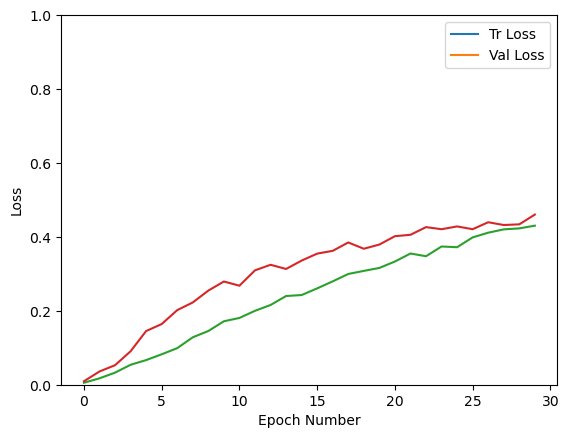

In [59]:
history = np.array(history)
plt.plot(history[:,0:4])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()


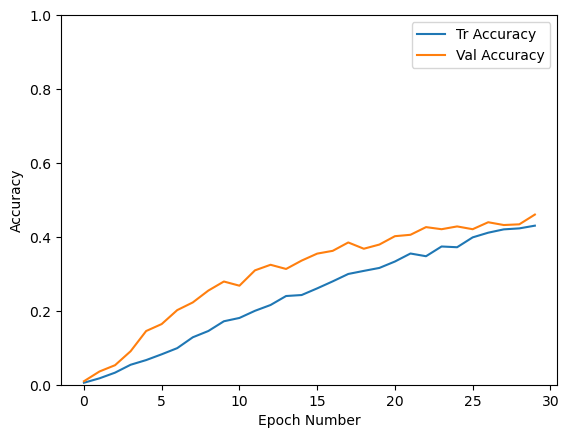

In [21]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print('Using device:', device)
model=torch.load('/Users/shahriyar/Desktop/programming/Python/ML/Pytorch/image_classification/renet50_model_1.pt').to(device)
resnet50_model.eval()

Using device: mps


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [77]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# # Assuming you have a model defined somewhere
# # model = YourModel()

# # Define the test dataset and DataLoader
# test_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

# test_dataset = datasets.MNIST(root='./data', train=False, transform=test_transform, download=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
# model.to(device)
# resnet50_model.eval()

# Disable gradient calculation
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        model.to(device)
        
        outputs = model(images).to(device)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Accuracy of the model on the test set: {accuracy * 100:.2f}%')
    print(device)

Accuracy of the model on the test set: 42.55%
mps


In [58]:
batch_size = 4
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(200)]
    n_class_samples = [0 for i in range(200)]
    for images, labels in test_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')



Accuracy of the network: 42.54894127047543 %


In [70]:
def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            
            # inputs = inputs.to(device, dtype=torch.float32)
            
            # to(device, dtype=torch.float32)
            
            # inputs = inputs.type(torch.FloatTensor).to(device)
            
            labels = labels.to(device)
            model=model.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs).to(device)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))


In [82]:

def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']


    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).to(device)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)

        topk, topclass = ps.topk(3, dim=1)
        cls = idx_to_class[topclass.cpu().numpy()[0][0]]
        score = topk.cpu().numpy()[0][0]

        for i in range(3):
            print("Predcition", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])
            print(device)




Predcition 1 : 001.Black_footed_Albatross , Score:  0.15948997
mps
Predcition 2 : 003.Sooty_Albatross , Score:  0.12941837
mps
Predcition 3 : 045.Northern_Fulmar , Score:  0.0971827
mps


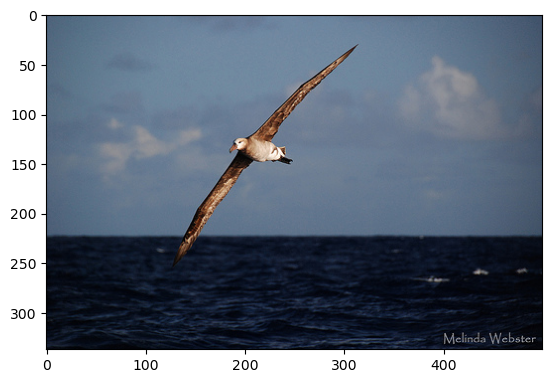

In [83]:

# torch.set_default_device("mps")
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Using device:', device)

# model = torch.load("/Users/shahriyar/Desktop/programming/Python/ML/Pytorch/birds_classification/data_model_29.pt").to(device)
predict(model, '/Users/shahriyar/Desktop/programming/Python/ML/Pytorch/birds_classification/data/train/001.Black_footed_Albatross/Black_footed_Albatross_0004_2731401028.jpg')


        
        

In [71]:
computeTestSetAccuracy(model, loss_func)

Test Batch number: 000, Test: Loss: 2.4225, Accuracy: 0.5000
Test Batch number: 001, Test: Loss: 2.6920, Accuracy: 0.4062
Test Batch number: 002, Test: Loss: 2.4474, Accuracy: 0.4688
Test Batch number: 003, Test: Loss: 2.5630, Accuracy: 0.4688
Test Batch number: 004, Test: Loss: 2.4178, Accuracy: 0.4375
Test Batch number: 005, Test: Loss: 2.7590, Accuracy: 0.3438
Test Batch number: 006, Test: Loss: 2.6104, Accuracy: 0.4062
Test Batch number: 007, Test: Loss: 2.6164, Accuracy: 0.3438
Test Batch number: 008, Test: Loss: 2.1602, Accuracy: 0.4375
Test Batch number: 009, Test: Loss: 2.1645, Accuracy: 0.4688
Test Batch number: 010, Test: Loss: 2.5487, Accuracy: 0.4688
Test Batch number: 011, Test: Loss: 2.4460, Accuracy: 0.4688
Test Batch number: 012, Test: Loss: 2.3884, Accuracy: 0.5312
Test Batch number: 013, Test: Loss: 2.4520, Accuracy: 0.5000
Test Batch number: 014, Test: Loss: 2.3991, Accuracy: 0.4375
Test Batch number: 015, Test: Loss: 2.3938, Accuracy: 0.4062
Test Batch number: 016, 